In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats
import seaborn as sns

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

In [5]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\echo_analysis'

### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Choose subject

In [7]:
data_loc = r"F:\ZZmanuscript_eLife\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1"
exp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)
expname = data_loc[data_loc.find('mouse')+12:data_loc.find('experiment')-1]
print(expname)

Experiment type: electrical and sensory stimulation
estim_vis_2021-04-08_10-28-24


In [8]:
## Grab exp metadata from Templeton-log_exp ##
if np.any([True if exp.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(exp.mouse)) & (Temp_metadata['exp_name'].str.contains(expname))
    )].squeeze()
elif np.any([True if exp.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(exp.mouse)) & (ZZ_metadata['exp_name'].str.contains(expname))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(exp.mouse, expname))

In [9]:
print(exp_meta['brain states'])

awake/ISO/recovery/recovery


In [10]:
sweep_state_list = ['awake', 'isoflurane', 'recovery', 'recovery']

In [11]:
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

[]


In [12]:
## Load stim log and apply sweep labels ##
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,state
0,biphasic,40,375.08634,375.08674,0.0004,0,True,0.0,True,awake
1,biphasic,15,378.61936,378.61976,0.0004,0,True,0.0,True,awake
2,biphasic,40,382.68098,382.68138,0.0004,0,True,0.0,True,awake
3,biphasic,60,387.06326,387.06366,0.0004,0,True,0.0,True,awake
4,biphasic,60,391.23287,391.23327,0.0004,0,True,0.0,True,awake


In [13]:
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
else:
    estim_current = {'mid': str(currents[0])}
print(estim_current)

{'low': '15', 'mid': '40', 'high': '60'}


In [14]:
## Load EEG traces ##
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [15]:
manual_1stpk_annots_file = os.path.join(exp.data_folder, 'manual_first_peak_detection.npy')
if os.path.exists(manual_1stpk_annots_file):
    annots = np.load(os.path.join(exp.data_folder, 'manual_first_peak_detection.npy'))
    print(len(annots))
else:
    print('No annotations file found.')

10


### Calculate global field power (GFP) and the rectified mean EP (a la Simone)

In [16]:
all_gfp = np.std(all_EEG_traces[:, GOOD_CHS, :], axis=1)
all_rectmean = np.mean(np.abs(all_EEG_traces[:, GOOD_CHS, :]), axis=1)

### Set some parameters

In [17]:
## Choose windows ##
windows = {'first': [0.002, 0.025], 'second': [0.1, 0.25]}
## Simone: 'early': [0.003, 0.05], 'late': [0.15, 0.25]

## Set threshold for 1st peak detection ##
first_peak_zthresh = 3

### Calculate 1st peak z-value in GFP

In [18]:
all_mean_gfp = np.mean(all_gfp[EEG_event_timestamps < 0, :], axis=0)
all_std_gfp = np.std(all_gfp[EEG_event_timestamps < 0, :], axis=0)

fwinds = np.nonzero((EEG_event_timestamps >= windows['first'][0]) & (EEG_event_timestamps <= windows['first'][1]))[0]
all_firstpeakmax = np.max(all_gfp[fwinds, :], axis=0)
all_firstpeakz = (all_firstpeakmax - all_mean_gfp) / all_std_gfp
firstpeak_mask = all_firstpeakz > first_peak_zthresh

### Calculate max of both peaks in rectified mean

In [19]:
peak_maxs = {}
bl_maxs = {}
for winname, windowi in windows.items():
    epinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
    blinds = np.nonzero((EEG_event_timestamps >= -windowi[1]) & (EEG_event_timestamps <= -windowi[0]))[0]
    peak_maxs[winname] = np.max(all_rectmean[epinds, :], axis=0)
    bl_maxs[winname] = np.max(all_rectmean[blinds, :], axis=0)

## Plot one trial

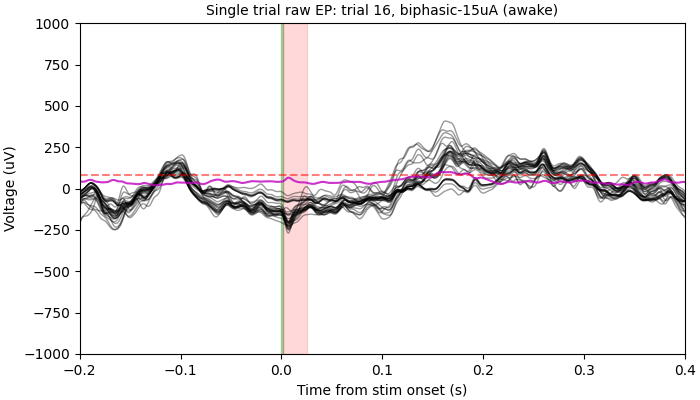

In [36]:
triali = 16
trialtraces = all_EEG_traces[:,:,triali]

fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
ax.axvspan(0, 0.002, color='g', alpha=0.3)
ax.axvspan(windows['first'][0], windows['first'][1], color='r', alpha=0.15)
# ax.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.1)
ax.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.4)
# ax.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.8)
ax.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.8)

ax.axhline(all_mean_gfp[triali] + (first_peak_zthresh * all_std_gfp[triali]), color='r', linestyle='dashed', alpha=0.5)

ax.set_xlim([-0.2, 0.4])
ax.set_ylim([-1000, 1000])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Single trial raw EP: trial {:d}, {}-{}uA ({})'.format(
    triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter, stim_log.iloc[triali].state))

## Save ##
# figname = 'awakeEP_d1d2_PCI_{}.png'.format(date.today().strftime('%b%d%Y'))
figname = 'm{}_rawEP_trial{:d}_GFP_1stpk.png'.format(exp.mouse, triali)
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Text(0.5, 0.98, 'Single trial EP: trial 520, biphasic-15uA (isoflurane)')

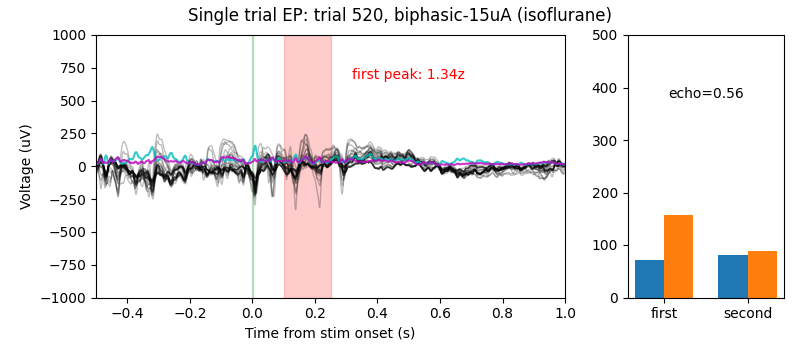

In [35]:
triali = 520
trialtraces = all_EEG_traces[:,:,triali]

fig = plt.figure(figsize=(8, 3.5))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3,1], left=0.12, right=0.98, top=0.9, bottom=0.15, wspace=0.2)
axEEG = fig.add_subplot(gs[0])
axpks = fig.add_subplot(gs[1])

axEEG.axvspan(0, 0.002, color='g', alpha=0.2)
axEEG.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
axEEG.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.25)
axEEG.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.8)
axEEG.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.8)
axEEG.set_xlim([-0.5, 1.0])
axEEG.set_ylim([-1000, 1000])
axEEG.set_xlabel('Time from stim onset (s)')
axEEG.set_ylabel('Voltage (uV)')
if firstpeak_mask[triali]:
    axEEG.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
else:
    axEEG.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

xb = np.arange(len(windows))
wd = 0.35
axpks.bar(xb - wd/2, [bl_maxs['first'][triali], bl_maxs['second'][triali]], wd)
axpks.bar(xb + wd/2, [peak_maxs['first'][triali], peak_maxs['second'][triali]], wd)
axpks.set_xticks(xb)
axpks.set_xticklabels(['first', 'second'])
axpks.set_ylim([0, 500])
echoi = peak_maxs['second'][triali] / peak_maxs['first'][triali]
axpks.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 400), ha='center', va='top', color='k')

fig.suptitle('Single trial EP: trial {:d}, {}-{}uA ({})'.format(
    triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter, stim_log.iloc[triali].state))

### Next: plot some example trials then test "echo" metric with trials that have 1st peak vs all trials

Text(0.5, 0.98, 'Single trial raw EPs - awake')

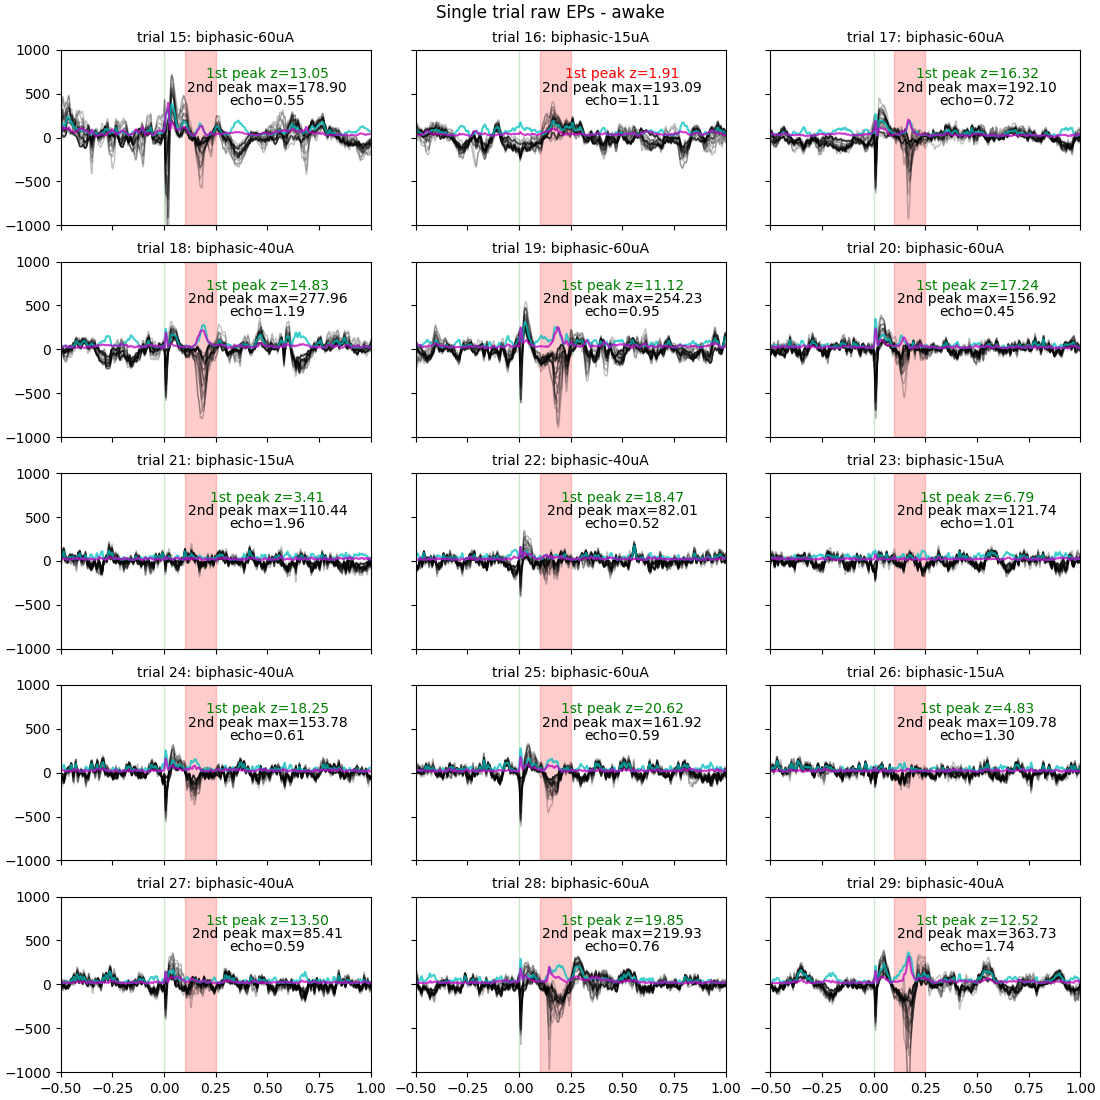

In [37]:
itrial = 15

fig, axs = plt.subplots(5, 3, figsize=(11,11), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+15)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.75)
    axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    echoi = peak_maxs['second'][triali] / peak_maxs['first'][triali]
    if firstpeak_mask[triali]:
        axi.annotate('1st peak z={:.2f}'.format(all_firstpeakz[triali]), xy=(0.5, 800), ha='center', va='top', color='g')
    else:
        axi.annotate('1st peak z={:.2f}'.format(all_firstpeakz[triali]), xy=(0.5, 800), ha='center', va='top', color='r')
    axi.annotate('2nd peak max={:.2f}'.format(peak_maxs['second'][triali]), xy=(0.5, 650), ha='center', va='top', color='k')
    axi.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 500), ha='center', va='top', color='k')

axi.set_xlim([-0.5, 1.0])
axi.set_ylim([-1000, 1000])
plt.suptitle('Single trial raw EPs - {}'.format(stim_log.iloc[itrial].state))

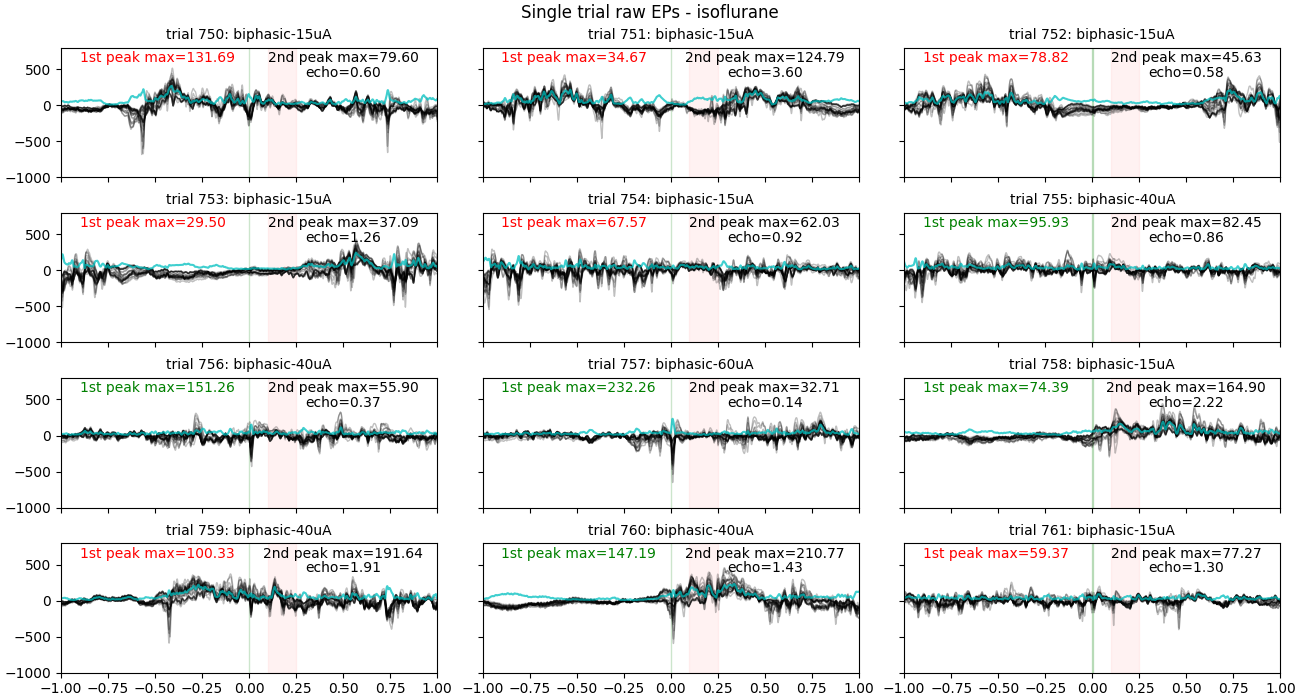

In [56]:
## Optimize for ppt slide
itrial = 750

fig, axs = plt.subplots(4, 3, figsize=(13,7), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+12)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.05)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.75)
    # axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    echoi = peak_maxs['second'][triali] / peak_maxs['first'][triali]
    if firstpeak_mask[triali]:
        axi.annotate('1st peak max={:.2f}'.format(peak_maxs['first'][triali]), xy=(-0.9, 750), ha='left', va='top', color='g')
    else:
        axi.annotate('1st peak max={:.2f}'.format(peak_maxs['first'][triali]), xy=(-0.9, 750), ha='left', va='top', color='r')
    axi.annotate('2nd peak max={:.2f}'.format(peak_maxs['second'][triali]), xy=(0.5, 750), ha='center', va='top', color='k')
    axi.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 550), ha='center', va='top', color='k')

axi.set_xlim([-1.0, 1.0])
axi.set_ylim([-1000, 800])
plt.suptitle('Single trial raw EPs - {}'.format(stim_log.iloc[itrial].state))

## Save ##
figname = 'm{}_rawEPs_{}{:d}.png'.format(exp.mouse, stim_log.iloc[itrial].state, itrial)
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Compare peak detection across trial types

In [37]:
comp_states = ['awake', 'isoflurane']
fractions = np.zeros((len(comp_states), len(estim_current)), dtype=float)
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        fractions[ri,ci] = np.sum(firstpeak_mask[eventinds]) / len(eventinds)

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


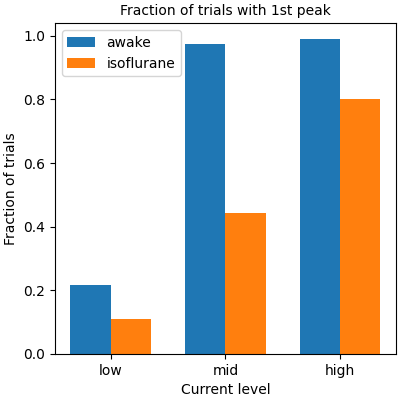

In [39]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
x = np.arange(len(estim_current))  # the label locations
width = 0.35  # the width of the bars
ax.bar(x - width/2, fractions[0,:], width, label=comp_states[0])
ax.bar(x + width/2, fractions[1,:], width, label=comp_states[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of trials')
ax.set_ylim([0, 1.04])
ax.set_title('Fraction of trials with 1st peak')
ax.set_xticks(x)
ax.set_xticklabels(estim_current.keys())
ax.set_xlabel('Current level')
ax.legend()

## Save ##
figname = 'm{}_1stpk_zthresh.png'.format(exp.mouse)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Compare echo and 2nd peak max

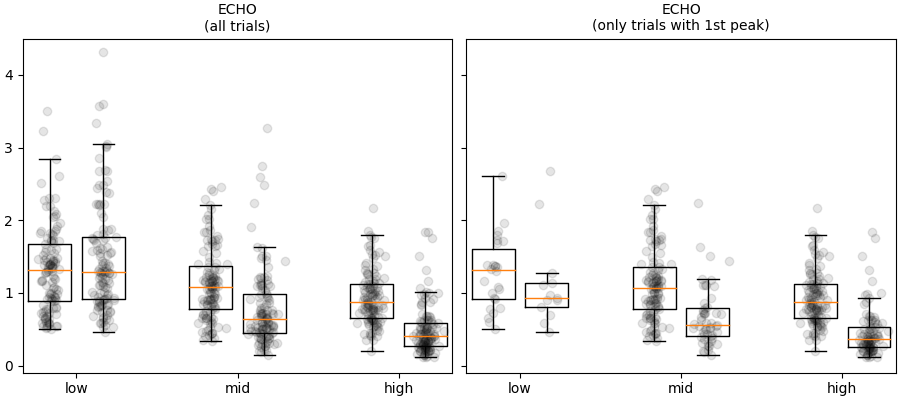

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True, sharey=True)
blocs = np.arange(len(estim_current) * (len(comp_states) + 1)).reshape((len(comp_states) + 1), len(estim_current))
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        y_values = peak_maxs['second'][eventinds] / peak_maxs['first'][eventinds]
        x_values = np.random.normal(blocs[ci,ri], 0.1, len(y_values))
        axs[0].scatter(x_values, y_values, c='k', marker='o', alpha=0.1)
        axs[0].boxplot(y_values, positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

        axs[1].scatter(x_values[firstpeak_mask[eventinds]], y_values[firstpeak_mask[eventinds]], c='k', marker='o', alpha=0.1)
        axs[1].boxplot(y_values[firstpeak_mask[eventinds]], positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

axs[0].set_title('ECHO\n(all trials)')
axs[0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0].set_xticklabels(estim_current.keys())
axs[0].set_ylim([-0.1, 4.5])

axs[1].set_title('ECHO\n(only trials with 1st peak)')
axs[1].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1].set_xticklabels(estim_current.keys())

## Save ##
figname = 'm{}_echo.png'.format(exp.mouse)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

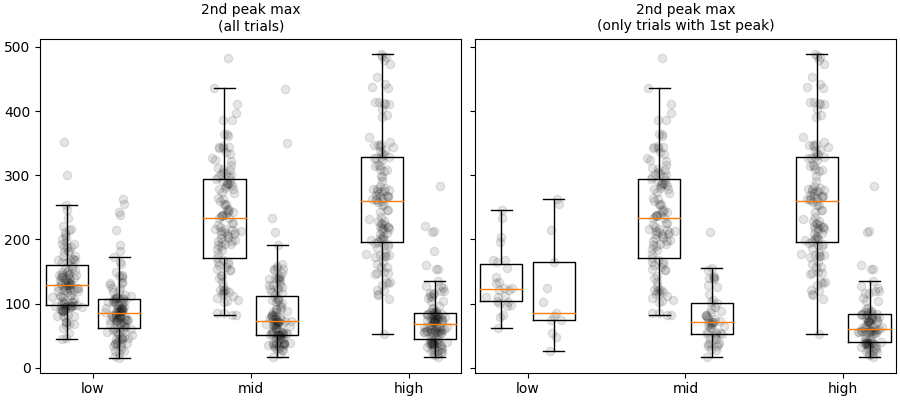

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True, sharey=True)
blocs = np.arange(len(estim_current) * (len(comp_states) + 1)).reshape((len(comp_states) + 1), len(estim_current))
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        y_values = peak_maxs['second'][eventinds]
        x_values = np.random.normal(blocs[ci,ri], 0.1, len(y_values))
        axs[0].scatter(x_values, y_values, c='k', marker='o', alpha=0.1)
        axs[0].boxplot(y_values, positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

        axs[1].scatter(x_values[firstpeak_mask[eventinds]], y_values[firstpeak_mask[eventinds]], c='k', marker='o', alpha=0.1)
        axs[1].boxplot(y_values[firstpeak_mask[eventinds]], positions=[blocs[ci,ri]], widths=[0.8], showfliers=False)

axs[0].set_title('2nd peak max\n(all trials)')
axs[0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[0].set_xticklabels(estim_current.keys())

axs[1].set_title('2nd peak max\n(only trials with 1st peak)')
axs[1].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1].set_xticklabels(estim_current.keys())

## Save ##
figname = 'm{}_2ndpkmax.png'.format(exp.mouse)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Plotting multiple trials

Plotting

<ErrorbarContainer object of 3 artists>

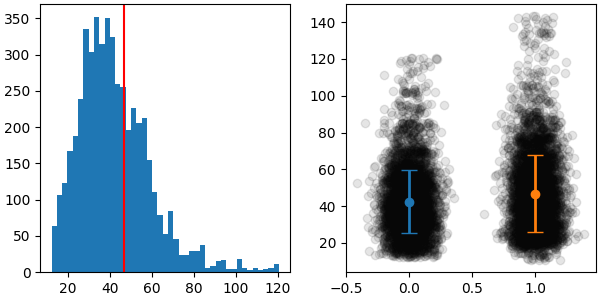

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
blvals = gfptrace[EEG_event_timestamps < 0]
epvals = gfptrace[EEG_event_timestamps > 0]

axs[0].hist(blvals)
axs[0].axvline(np.mean(epvals), color='r')

x0s = np.random.normal(0, 0.1, len(blvals))
axs[1].scatter(x0s, blvals, c='k', marker='o', alpha=0.1)
axs[1].errorbar(0, np.mean(blvals), np.std(blvals), fmt='o', linewidth=2, capsize=6)

x1s = np.random.normal(1, 0.1, len(epvals))
axs[1].scatter(x1s, epvals, c='k', marker='o', alpha=0.1)
axs[1].errorbar(1, np.mean(epvals), np.std(epvals), fmt='o', linewidth=2, capsize=6)

Text(0.5, 1.0, 'Single trial EP (raw) trial 18: biphasic-40uA')

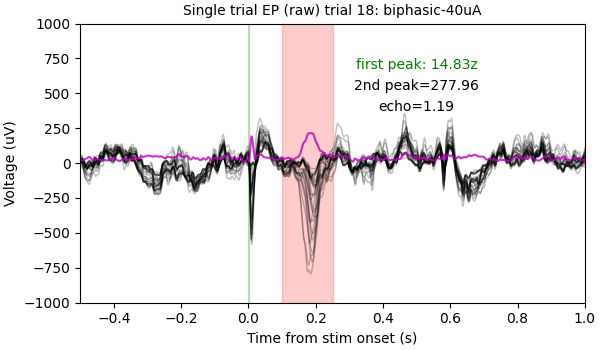

In [30]:
triali = 18
trialtraces = all_EEG_traces[:,:,triali]
gfptrace = all_gfp[:,triali]

fig, ax = plt.subplots(figsize=(6,3.5), constrained_layout=True)

ax.axvspan(0, 0.002, color='g', alpha=0.2)
ax.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
ax.plot(EEG_event_timestamps, trialtraces, c='k', linewidth=1.0, alpha=0.25)
ax.plot(EEG_event_timestamps, gfptrace, c='m', linewidth=1.5, alpha=0.8)
ax.set_xlim([-0.5, 1.0])
ax.set_ylim([-1000, 1000])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (uV)')

if all_firstpeakz[triali] > first_peak_zthresh:
    ax.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    echoi = pkmaxs['second'][triali] / pkmaxs['first'][triali]
    ax.annotate('2nd peak={:.2f}'.format(pkmaxs['second'][triali]), xy=(0.5, 600), ha='center', va='top', color='k')
    ax.annotate('echo={:.2f}'.format(echoi), xy=(0.5, 450), ha='center', va='top', color='k')
else:
    ax.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

ax.set_title('Single trial EP (raw) trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

##### Plot several trials

Awake

Text(0.5, 0.98, 'Single trial EPs (raw): awake')

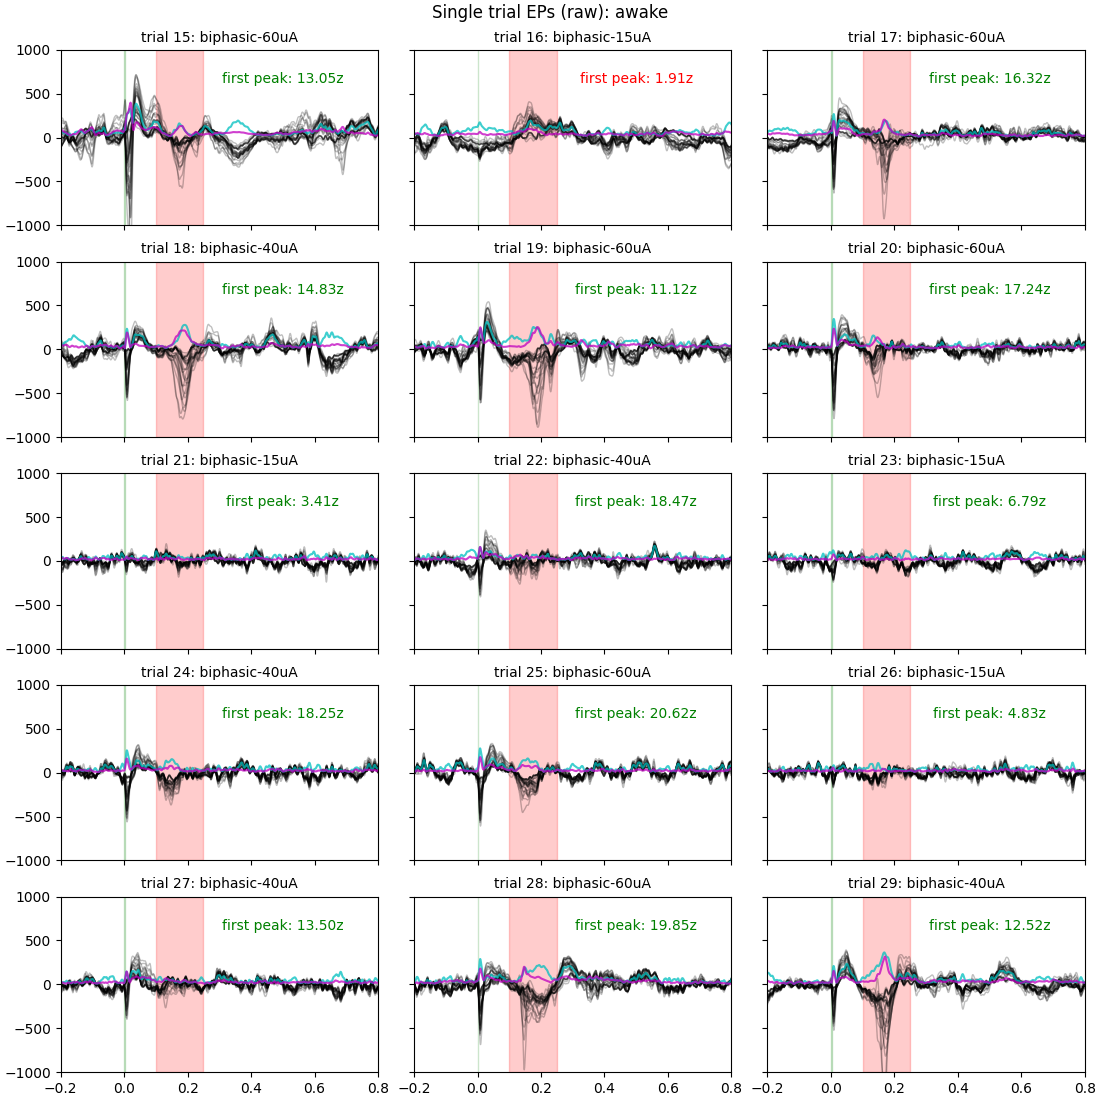

In [66]:
itrial = 15

fig, axs = plt.subplots(5, 3, figsize=(11,11), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+15)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_rectmean[:,triali], c='c', linewidth=1.5, alpha=0.75)
    axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    if all_firstpeakz[triali] > first_peak_zthresh:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    else:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

axi.set_xlim([-0.2, 0.8])
axi.set_ylim([-1000, 1000])
plt.suptitle('Single trial EPs (raw): awake')

Isoflurane

Text(0.5, 0.98, 'Single trial EPs (raw): iso')

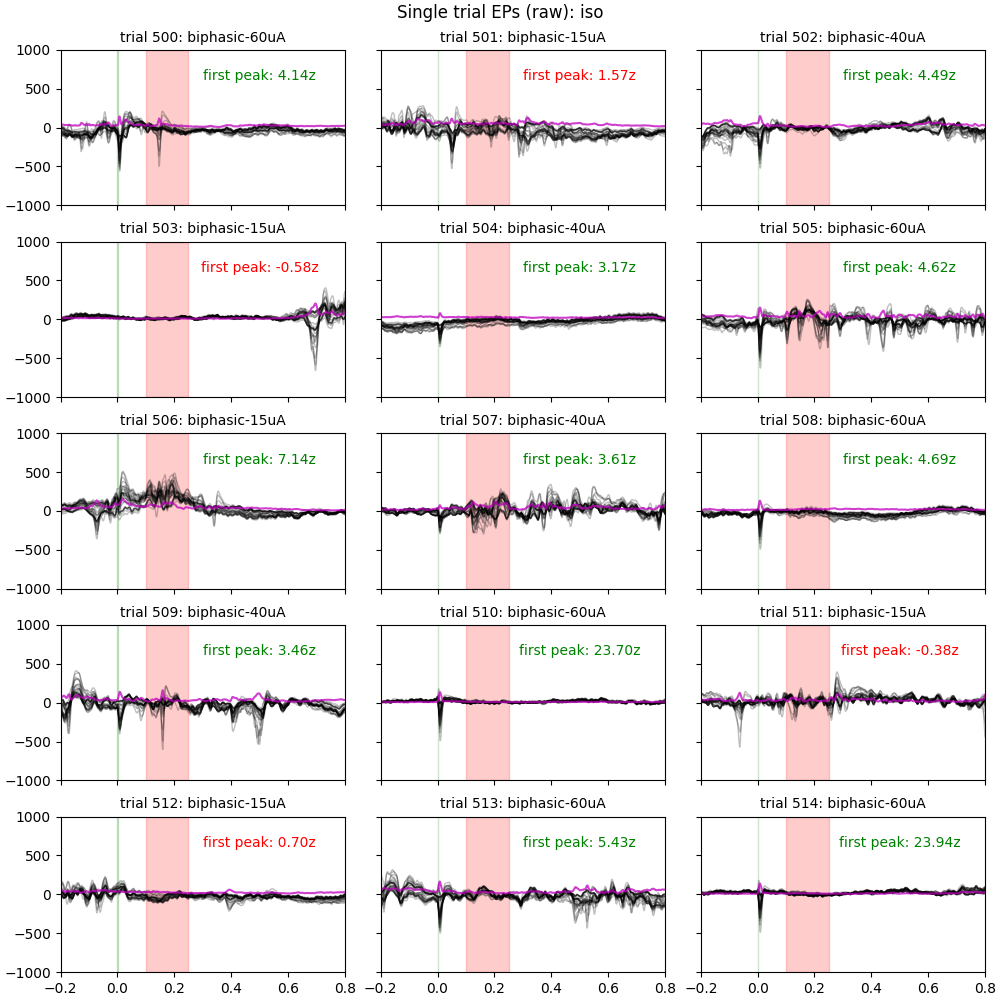

In [63]:
itrial = 500 # 480

fig, axs = plt.subplots(5, 3, figsize=(10,10), constrained_layout=True, sharex=True, sharey=True)

for axi, triali in zip(axs.flatten(), range(itrial, itrial+15)):
    axi.axvspan(0, 0.002, color='g', alpha=0.2)
    axi.axvspan(windows['second'][0], windows['second'][1], color='r', alpha=0.2)
    axi.plot(EEG_event_timestamps, all_EEG_traces[:,:,triali], c='k', linewidth=1.0, alpha=0.25)
    axi.plot(EEG_event_timestamps, all_gfp[:,triali], c='m', linewidth=1.5, alpha=0.75)
    axi.set_title('trial {:d}: {}-{}uA'.format(triali, stim_log.iloc[triali].stim_type, stim_log.iloc[triali].parameter))

    if all_firstpeakz[triali] > first_peak_zthresh:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='g')
    else:
        axi.annotate('first peak: {:.2f}z'.format(all_firstpeakz[triali]), xy=(0.5, 750), ha='center', va='top', color='r')

axi.set_xlim([-0.2, 0.8])
axi.set_ylim([-1000, 1000])
plt.suptitle('Single trial EPs (raw): iso')

In [54]:
comp_states = ['awake', 'isoflurane']
fractions = np.zeros((len(comp_states), len(estim_current)), dtype=float)
for ri, statei in enumerate(comp_states):
    for ci, (clevel, parami) in enumerate(estim_current.items()):
        print('{} - {}'.format(statei, parami))
        eventinds = get_events_wdict(stim_log, {'state': statei, 'parameter': parami}, out='index')
        fractions[ri,ci] = np.sum(all_firstpeakz[eventinds] > first_peak_zthresh) / len(eventinds)

awake - 15
awake - 40
awake - 60
isoflurane - 15
isoflurane - 40
isoflurane - 60


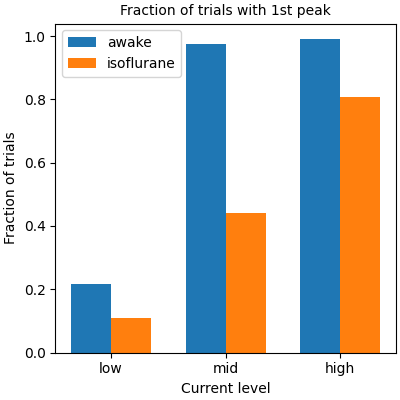

In [64]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
x = np.arange(len(estim_current))  # the label locations
width = 0.35  # the width of the bars
ax.bar(x - width/2, fractions[0,:], width, label=comp_states[0])
ax.bar(x + width/2, fractions[1,:], width, label=comp_states[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of trials')
ax.set_ylim([0, 1.04])
ax.set_title('Fraction of trials with 1st peak')
ax.set_xticks(x)
ax.set_xticklabels(estim_current.keys())
ax.set_xlabel('Current level')
ax.legend()

This is using the global field power (GFP) to detect the presence of a 1st peak. If the max GFP within [0, 0.025] s exceeds 3 standard deviations above the baseline GFP values (from [-2.0, 0] s), then the trial is considered to have a 1st peak.
<br>For mouse 569064, this appears to be working as expected: mid and high currents evoke a first peak almost every trial in the awake state and there are fewer trials with detected first peaks in the isoflurane state.